# Damien Ha ECE M148

# Project 3 - Classify your own data

For this project we're going to explore some of the new topics since the last project including Decision Trees and Un-supervised learning. The final part of the project will ask you to perform your own data science project to classify a new dataset.



## Submission Details

**Project is due June 14th at 11:59 am (Wednesday Afternoon). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend downloading [Latex](https://www.latex-project.org/) and print the notebook using Latex.**

## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

In [2]:
#Helper functions
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=0)
    plt.yticks(np.arange(num_classes), classes)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gca().xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    


# Example Project using new techniques 

Since project 2, we have learned about a few new models for supervised learning(Decision Trees and Neural Networks) and un-supervised learning (Clustering and PCA). In this example portion, we will go over how to implement these techniques using the Sci-kit learn library.

## Load and Process Example Project Data


For our example dataset, we will use the [Breast Cancer Wisconsin Dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to determine whether a mass found in a body is benign or malignant. Since this dataset was used as an example in project 2, you should be fairly familiar with it.

Feature Information:

Column 1: ID number

Column 2: Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    1. radius (mean of distances from center to points on the perimeter)
    2. texture (standard deviation of gray-scale values)
    3. perimeter
    4. area
    5. smoothness (local variation in radius lengths)
    6. compactness (perimeter^2 / area - 1.0)
    7. concavity (severity of concave portions of the contour)
    8. concave points (number of concave portions of the contour)
    9. symmetry
    10. fractal dimension ("coastline approximation" - 1)

Due to the statistical nature of the test, we are not able to get exact measurements of the previous values. Instead, the dataset contains the mean and standard error of the real-valued features. 

Columns 3-12 present the mean of the measured values

Columns 13-22 present the standard error of the measured values

In [3]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/breast_cancer_data.csv')

#Drop id column
data = data.drop(["id"],axis= 1)

#Transform target feature into numerical
le = LabelEncoder() 
data['diagnosis'] = le.fit_transform(data['diagnosis'])

#Split target and data
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [4]:
target.value_counts()

diagnosis
0    285
1    170
Name: count, dtype: int64

In [5]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
diagnosis
0    72
1    42
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class:  0.631578947368421


## Supervised Learning: Decision Tree


### Classification with Decision Tree

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


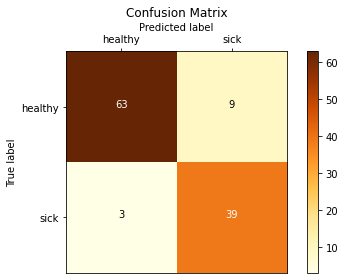

In [7]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

###  Parameters for Decision Tree Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into the Decision Tree Classifier:

- criterion: {‘gini’, ‘entropy’, ‘log_loss’} default="gini"
    - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain 
- splitter: {“best”, “random”}, default=”best”
    - The strategy used to choose the split at each node. “best” aims to find the best feature split amongst all features. "random" only looks for the best split amongst a random subset of features.
- max_depth: int, default = 2 {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    - The maximum depth of the tree.
- min_samples_split: int or float, default=2
    - The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

### Visualizing Decision Trees

Scikit-learn allows us to visualize the decision tree to see what features it choose to split and what the result is. Note that if the condition in the node is true, you traverse the left edge of the node. Otherwise, you traverse the right edge.

[Text(0.5, 0.8333333333333334, 'concave points_mean <= 0.011\ngini = 0.468\nsamples = 100.0%\nvalue = [0.626, 0.374]'),
 Text(0.25, 0.5, 'area_mean <= 0.124\ngini = 0.101\nsamples = 61.5%\nvalue = [0.946, 0.054]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'concavity_mean <= 0.001\ngini = 0.202\nsamples = 38.5%\nvalue = [0.114, 0.886]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

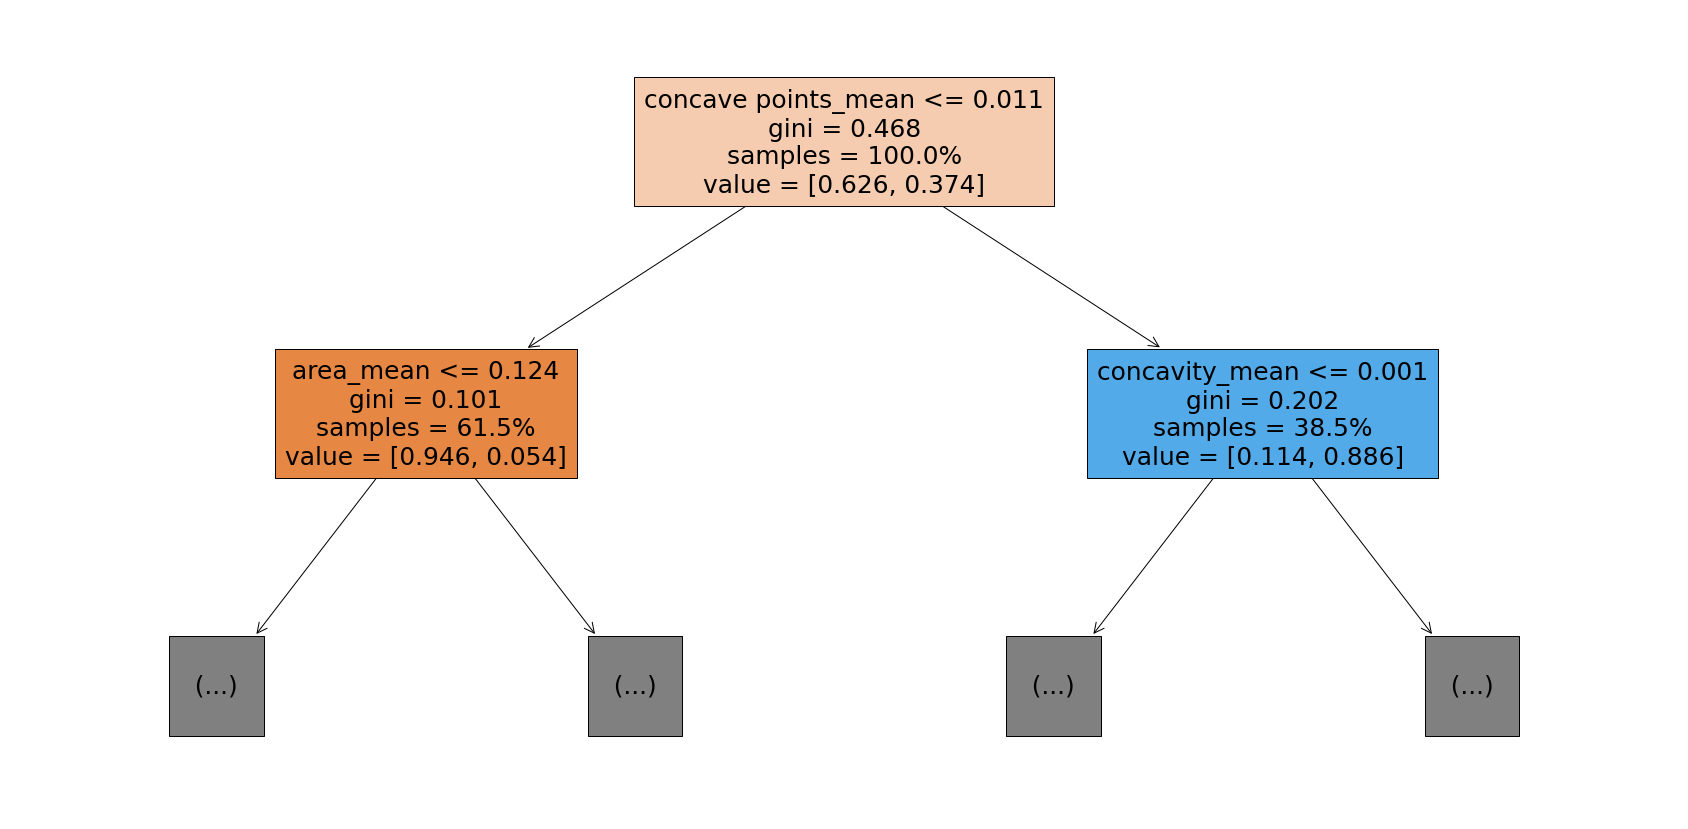

In [8]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

We can even look at the tree in a textual format.

In [9]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- concave points_mean <= 0.01
|   |--- area_mean <= 0.12
|   |   |--- area_se <= 0.04
|   |   |   |--- compactness_mean <= 0.59
|   |   |   |   |--- fractal_dimension_se <= -0.83
|   |   |   |   |   |--- fractal_dimension_se <= -0.84
|   |   |   |   |   |   |--- smoothness_se <= -1.22
|   |   |   |   |   |   |   |--- compactness_se <= -0.98
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- compactness_se >  -0.98
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- smoothness_se >  -1.22
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- fractal_dimension_se >  -0.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fractal_dimension_se >  -0.83
|   |   |   |   |   |--- class: 0
|   |   |   |--- compactness_mean >  0.59
|   |   |   |   |--- symmetry_se <= 0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- symmetry_se >  0.20
|   |   |   |   |   |--- class: 0
|   |   |--- area_se >  0.04
|   |   |   

### Feature Importance in Decision Trees

Decision Trees can also assign importance to features by measuring the average decrease in impurity (i.e. information gain) for each feature. The features with higher decreases are treated as more important. 

<Axes: >

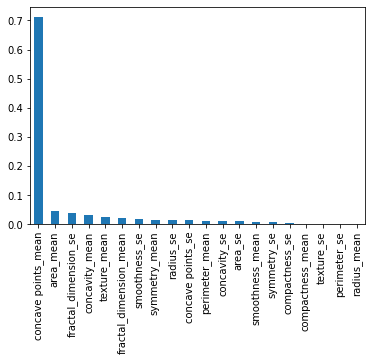

In [10]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

We can clearly see that "concave points_mean" has the largest importance due to it providing the most reduction in the impurity.

### Visualizing decision boundaries for Decision Trees

Similar to project 2, lets see what decision boundaries that a Decision Tree creates. We use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. 

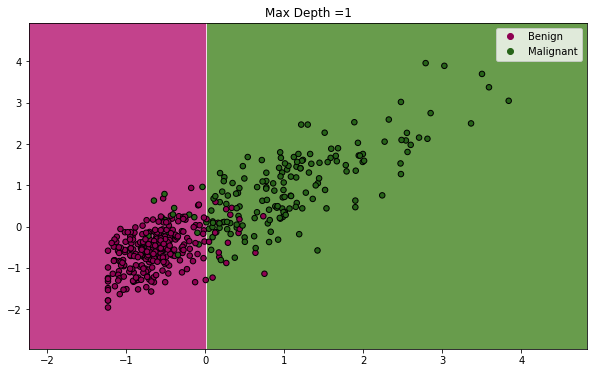

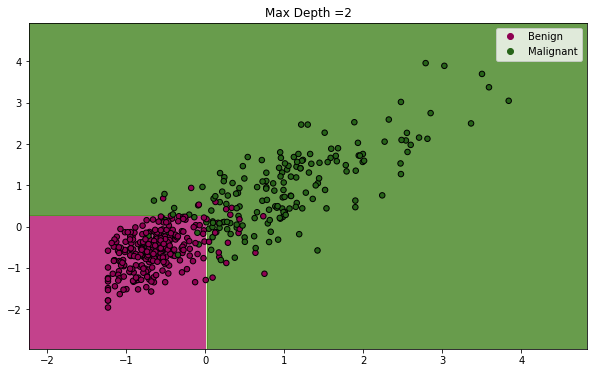

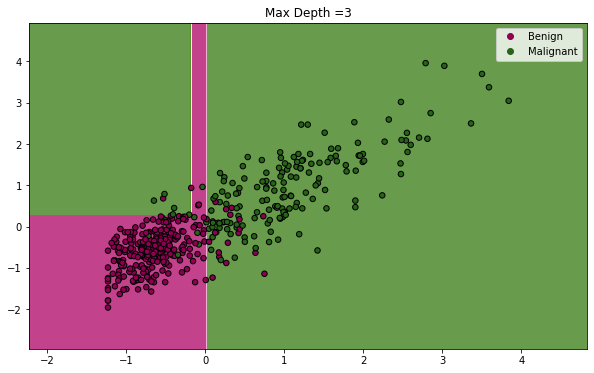

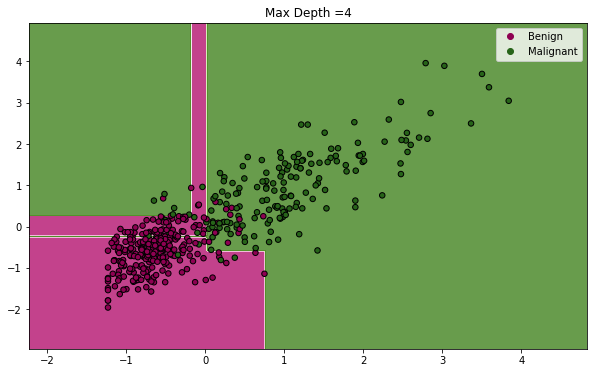

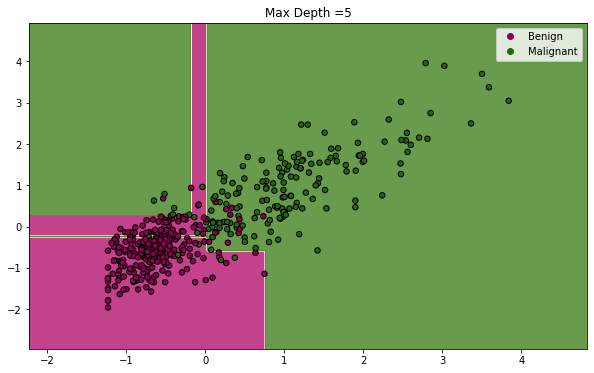

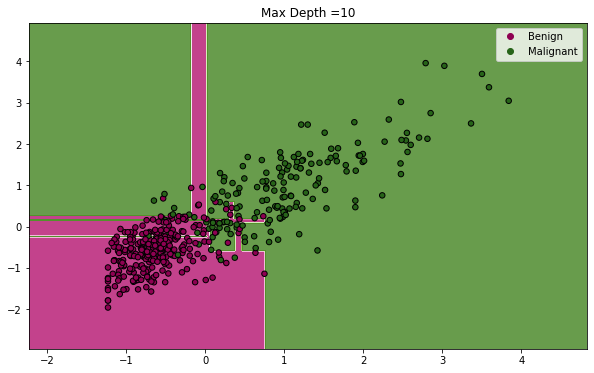

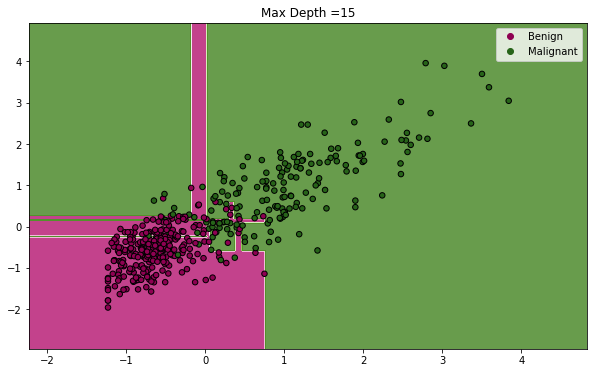

In [11]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

depth  = [1,2,3,4,5,10,15]
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split=7) 
    dt.fit(train_2, target)
    draw_contour(train_2,target,dt,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Max Depth ={d}")

We can see that the model gets more and more complex with increasing depth until it converges somewhere in between depth 10 and 15. 

## Supervised Learning: Multi-Layer Perceptron (MLP)

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks are very powerful tools that are used a in a variety of applications including image and speech processing. In class, we have discussed one of the earliest types of neural networks known as a Multi-Layer Perceptron. 

![steps](jupyter_images/mlp_example.png)

### Using MLP for classification

In [12]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter = 400)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.938596
Confusion Matrix: 
 [[67  5]
 [ 2 40]]


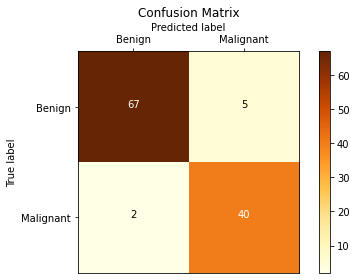

In [13]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

###  Parameters for MLP Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into MLP Classifier:

- hidden_layer_sizes: tuple, length = n_layers - 2, default=(100,)
    - The ith element represents the number of neurons in the ith hidden layer. 
- activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
    - Activation function for the hidden layer.
- alpha: float, default = 0.0001
    - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- max_iter: int, default=200
    - Maximum number of iterations taken for the solvers to converge.

### Visualizing decision boundaries for MLP

Now, lets see how the decision boundaries change as a function of both the activation function and the number of hidden layers.

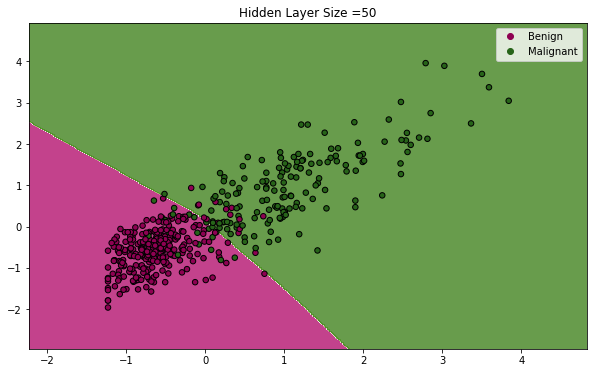

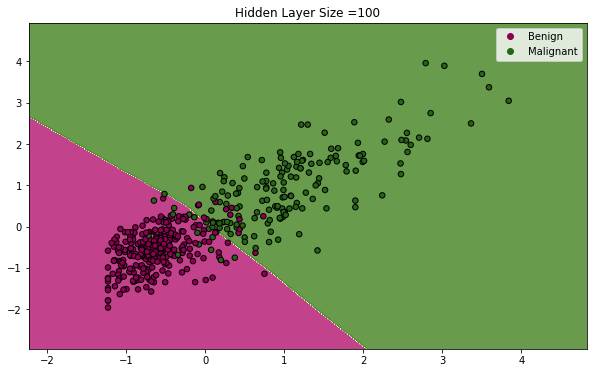

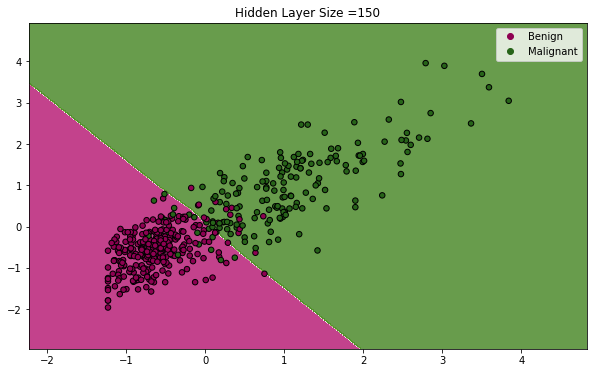

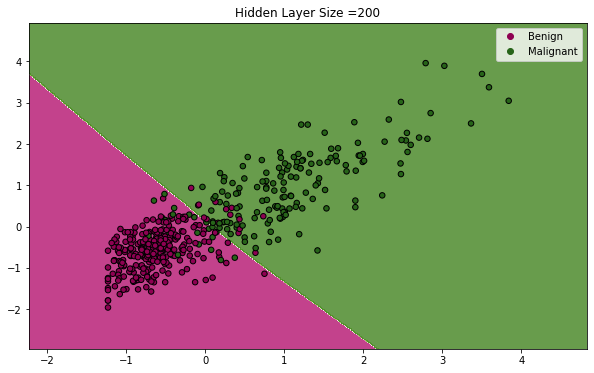

In [14]:
#Example of using the default Relu activation while altering the number of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Size ={l}")

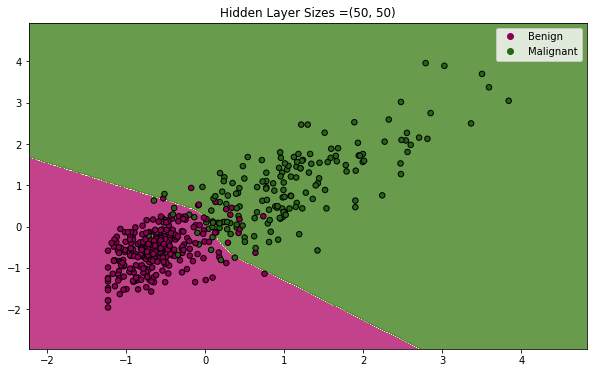

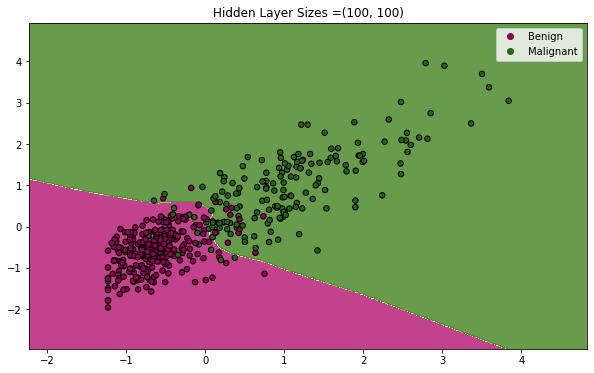

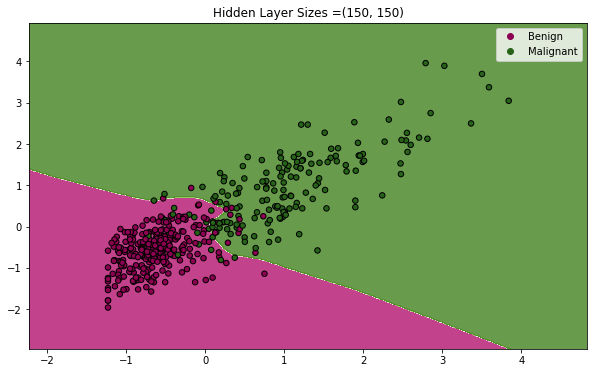

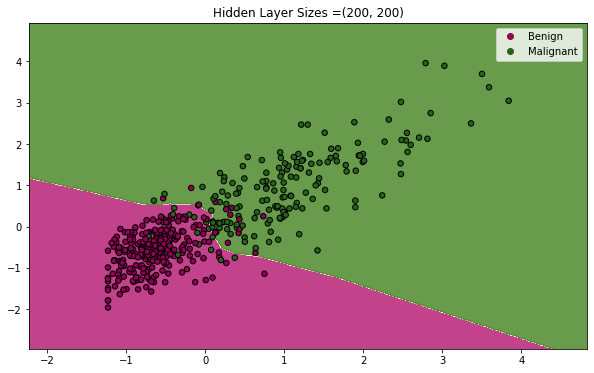

In [15]:
#Example of using the default Relu activation 
#while altering the number of hidden layers with 2 groups of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,l), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Sizes ={(l,l)}")

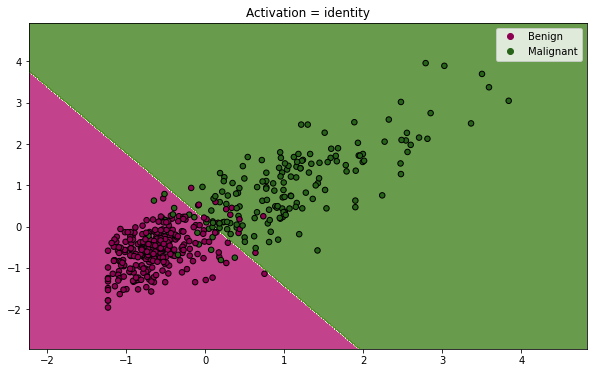

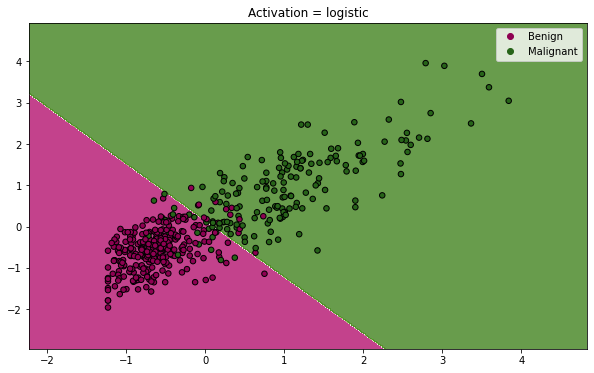

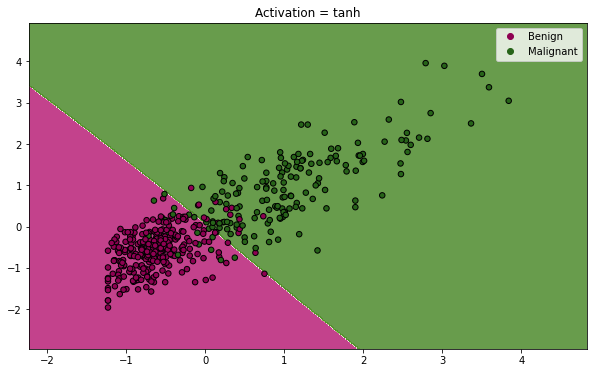

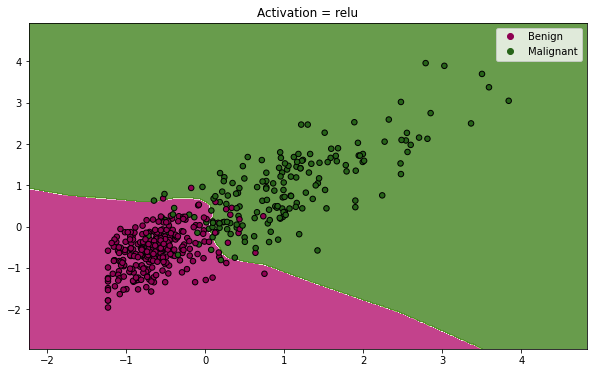

In [16]:
#Example of using 2 hidden layers of 100 units each with varying activations
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

acts  = ['identity', 'logistic', 'tanh', 'relu']
for act in acts:
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation = act, max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Activation = {act}")

## Unsupervised learning: PCA

As shown in lecture, PCA is a valuable dimensionality reduction tool that can extract a small subset of valuable features. In this section, we shall demonstrate how PCA can extract important visual features from pictures of subjects faces. We shall use the [AT&T Database of Faces](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces). This dataset contains 40 different subjects with 10 samples per subject which means we a dataset of 400 samples. 

We extract the images from the [scikit-learn dataset library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces). The library imports the images (faces.data), the flatten array of images (faces.images), and which subject eacj image belongs to (faces.target). Each image is a 64 by 64 image with pixels converted to floating point values in [0,1].

### Eigenfaces

The following codes downloads and loads the face data. 

In [17]:
#Import faces from scikit library
faces = datasets.fetch_olivetti_faces()
print("Flattened Face Data shape:", faces.data.shape)
print("Face Image Data Shape:", faces.images.shape)
print("Shape of target data:", faces.target.shape)


Flattened Face Data shape: (400, 4096)
Face Image Data Shape: (400, 64, 64)
Shape of target data: (400,)


In [18]:
#Extract image shape for future use
im_shape = faces.images[0].shape

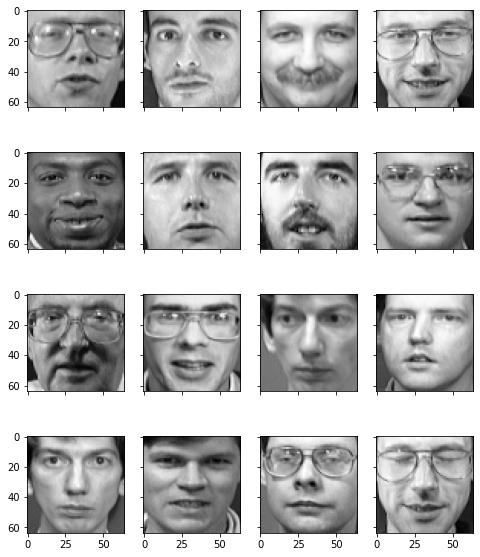

In [19]:
#Prints some example faces 
faceimages = faces.images[np.random.choice(len(faces.images),size= 16, replace = False)] # take random 16 images

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

Now, let us see what features we can extract from these face images.

In [20]:
#Perform PCA
from sklearn.decomposition import PCA
 
pca = PCA()
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(faces.data)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

The following plots the top 30 PCA components with how much variance does this feature explain.

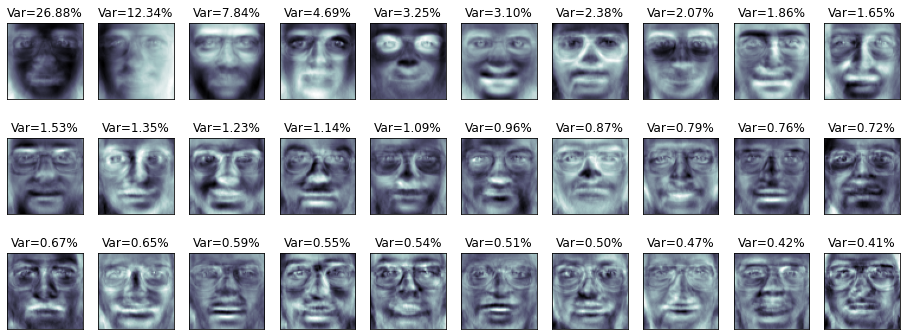

In [21]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(im_shape),
              cmap=plt.cm.bone)
    ax.set_title(f"Var={pca.explained_variance_ratio_[i]:.2%}")

Amazing! We can see that the model has learned to focus on many features that we as humans also look at when trying to identify a face such as the nose,eyes, eyebrows, etc.

With this feature extraction, we can perform much more powerful learning. 

### Feature Extraction for Classification

Lets see if we can use PCA to improve the accuracy of the decision tree classifier.

Accuracy without PCA
Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


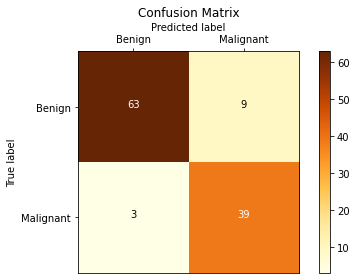

Accuracy with PCA
Accuracy:    0.912281
Confusion Matrix: 
 [[66  6]
 [ 4 38]]


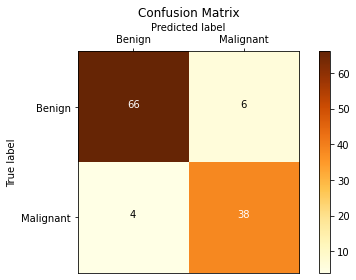

In [22]:
#Without PCA
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train, target)
predicted = clf.predict(test)

print("Accuracy without PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

#With PCA
pca = PCA(n_components = 0.9) #Take components that explain at lest 90% variance
       
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

In [23]:
print("Number of Features without PCA: ", train.shape[1])
print("Number of Features with PCA: ", train_new.shape[1])

Number of Features without PCA:  20
Number of Features with PCA:  7


Clearly, we get a much better accuracy for the model while using fewer features. But does the features the PCA thought were important the same features that the decision tree used. Lets look at the feature importance of the tree. The following plot numbers the first principal component as 0, the second as 1, and so forth.

<Axes: >

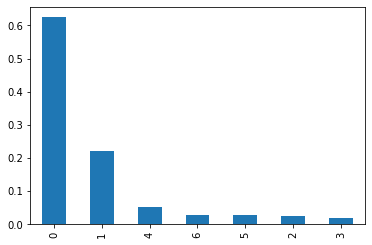

In [24]:
feature_names_new = list(range(train_new.shape[1]))
imp_pd = pd.Series(data = clf_pca.feature_importances_ ,index = feature_names_new)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

Amazingly, the first and second components were the most important features in the decision tree. Thus, we can claim that PCA has significantly improved the performance of our model. 

## Unsupervised learning: Clustering

Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups. One major algorithm we learned in class is the K-Means algorithm.

### Evaluating K-Means performance

While there are many ways to evaluate the [performance measure of clustering algorithsm](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), we will focus on the inertia score of the K-Means model. Inertia is another term for the sum of squared distances of samples to their closest cluster center. 

Let us look at how the Inertia changes as a function of the number of clusters for an artificial dataset.


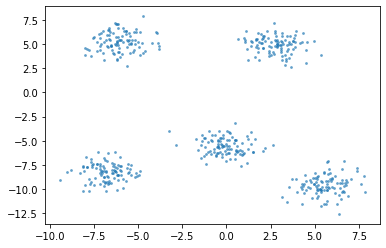

In [25]:
#Artifical Dataset
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=5,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=10,
)  # For reproducibility

plt.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7,edgecolor="k")

In [26]:
ks = list(range(2,10))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 2: 13293.997460961546
Inertia for K = 3: 7169.578996856773
Inertia for K = 4: 3247.8674040695832
Inertia for K = 5: 872.8554968701878
Inertia for K = 6: 803.846686425823


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/a

Inertia for K = 7: 739.5236191503768
Inertia for K = 8: 690.2530283275607
Inertia for K = 9: 614.5138307338655


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


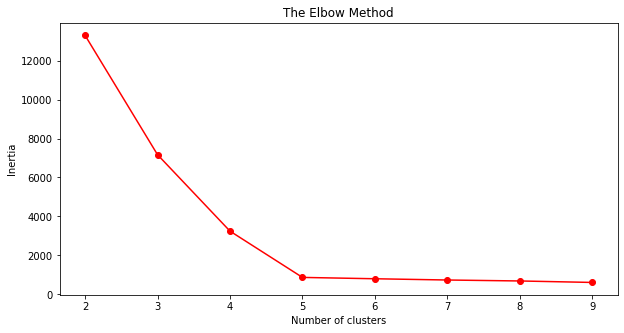

In [27]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

From the plot, we can see that when the number of clusters of K-means is the correct number of clusters, Inertia starts decreasing at a much slower rate. This creates a kind of elbow shape in the graph. For K-means clustering, the elbow method selects the number of clusters where the elbow shape is formed. In this case, we see that this method would produce the correct number of clusters.

Lets try it on the cancer dataset.

In [28]:
ks = list(range(2,30))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/a

Inertia for K = 2: 6381.278325955922
Inertia for K = 3: 5508.621446593709
Inertia for K = 4: 4972.231721973118
Inertia for K = 5: 4507.26713736607
Inertia for K = 6: 4203.777246823878


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 7: 3942.659550896411
Inertia for K = 8: 3745.1124228292692
Inertia for K = 9: 3532.7225156022073


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 10: 3371.033467027838
Inertia for K = 11: 3232.472758070737
Inertia for K = 12: 3135.1944201924534


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 13: 3033.3838427786477
Inertia for K = 14: 2958.3200036360367
Inertia for K = 15: 2893.798763511904


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 16: 2767.804761705547
Inertia for K = 17: 2737.4747101790635
Inertia for K = 18: 2662.1203080706655
Inertia for K = 19: 2617.90890694005
Inertia for K = 20: 2553.961378449726


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 21: 2491.9133737078346
Inertia for K = 22: 2448.777623600997


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 23: 2391.644588540416
Inertia for K = 24: 2374.1345787190176


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 25: 2334.794010981073
Inertia for K = 26: 2267.993521706617


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 27: 2233.585453239129
Inertia for K = 28: 2191.739402693569


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for K = 29: 2165.254207641313


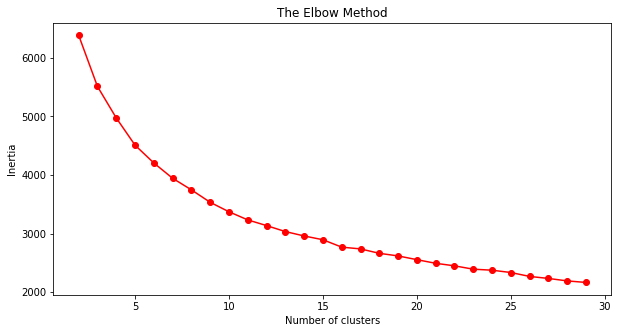

In [29]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Here we see that the elbow is not as cleanly defined. This may be due to the dataset not being a good fit for K-means. Regardless, we can still apply the elbow method by noting that the slow down happens around 7~14.

### Kmeans on Eigenfaces

Now, lets see how K-means performs in clustering the face data with PCA.

In [30]:
from sklearn.cluster import KMeans

n_clusters = 10 #We know there are 10 subjects
km = KMeans(n_clusters  = n_clusters,random_state=0)

pipe= Pipeline([("scaler",StandardScaler()), #First standardize
               ("pca",PCA()), #Transform using pca
         ("kmeans", km )]) #Then apply k means

In [31]:
clusters = pipe.fit_predict(faces.data)
print(clusters)

[3 6 3 4 6 4 3 3 3 6 5 5 5 5 5 5 5 5 5 5 1 1 5 1 4 1 4 4 6 6 5 5 5 3 6 4 3
 5 5 6 4 1 1 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 7 7 3 4 7 3 7 7 3 7 0 6 3 6
 3 3 6 3 3 6 1 1 1 4 4 4 4 4 1 6 6 6 6 6 6 6 6 6 4 3 0 0 0 0 0 0 0 0 0 0 4
 1 1 1 1 4 1 6 6 4 5 5 4 4 5 5 4 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 8 3 3 3 3 8 6 8 3 3 4 4 1 1 4 4 4 4 4 4 3 6 4 6 3 3 3 3 3 3 7 7 7 7 7
 7 7 7 7 7 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 8 9 4 2 2 2 2 2 2 2 2 2 2 3 6
 1 4 1 4 1 6 4 4 8 8 8 8 5 8 8 8 8 8 6 5 6 5 5 5 6 4 5 6 1 1 1 1 1 1 3 1 1
 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 1 4 2 2 2 9 4 4 9 8 2 2 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 5 7 7 7 9 9 9 9 9 9 9 9 9 9 2 2 2
 2 2 2 2 2 2 2 9 9 9 9 4 6 6 1 4 4 3 8 8 8 7 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1
 4 1 1 6 1 4 6 6 4 1 2 2 2 2 2 2 2 2 2 2 6 4 3 4 3 1 4 1 4 4]


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


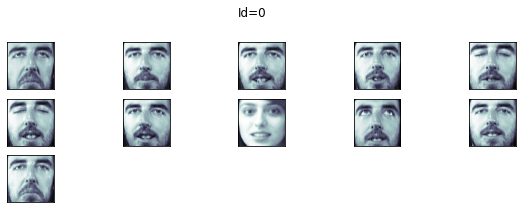

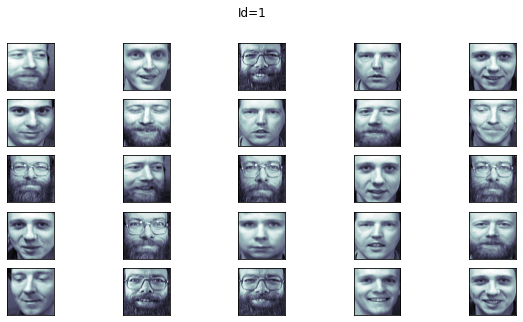

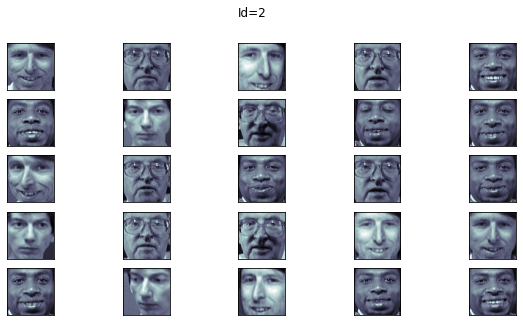

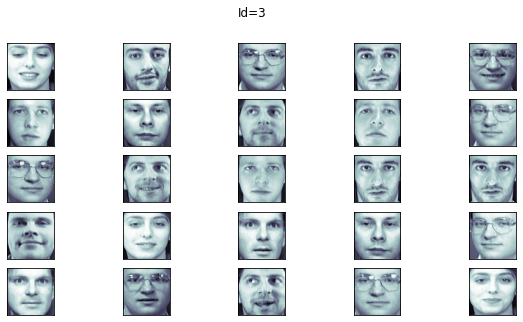

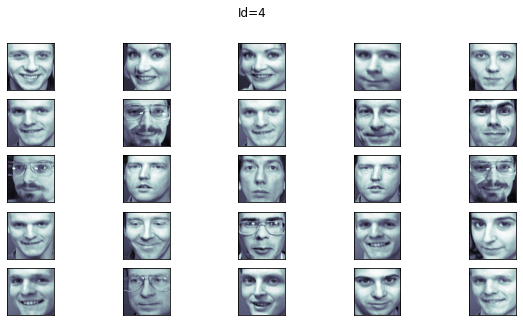

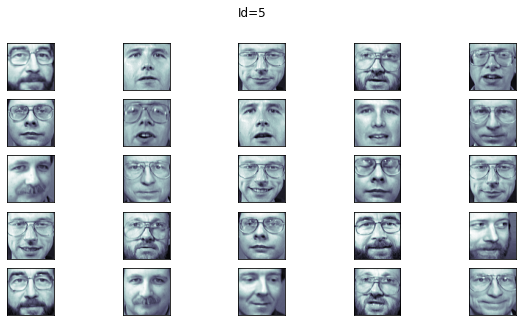

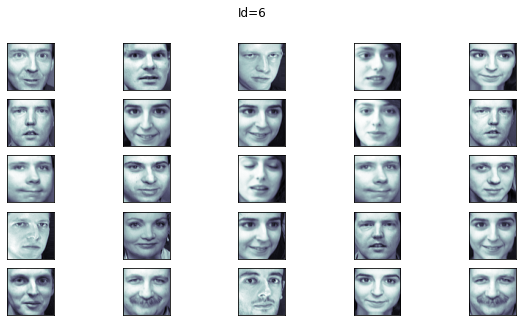

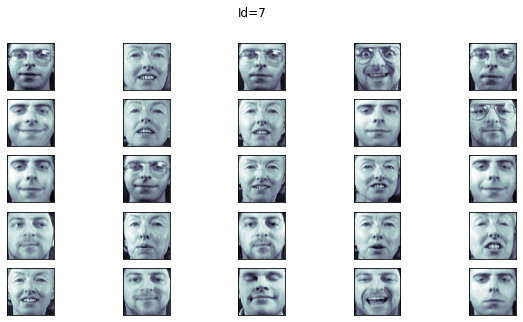

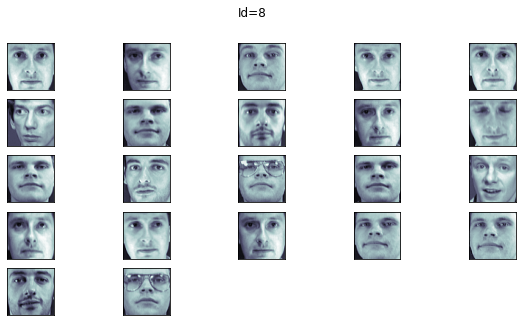

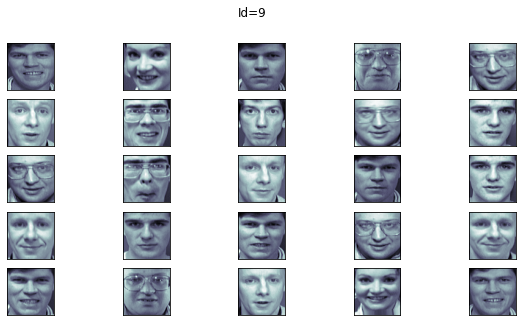

In [32]:
for labelID in range(n_clusters):
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    idxs = np.where(clusters == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)

    # Extract the sampled indexes
    id_face = faces.images[idxs]

    #Plots sampled faces
    fig = plt.figure(figsize=(10,5))
    for i in range(min(25,len(idxs))):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(id_face[i],
                  cmap=plt.cm.bone)
    fig.suptitle(f"Id={labelID}")

While the algorithm isn't perfect, we can see that K-means with PCA is picking up on some facial similarity or similar expressions. 

# (100 pts) Todo: Use new methods to classify heart disease

To compare how these new models perform with the other models discussed in the course, we will apply these new models on the heart disease dataset that was used in project 2.

## Background: The Dataset (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [33]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/heartdisease.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['target'] = le.fit_transform(data['sick'])
data = data.drop(["sick"], axis =1)

#Split target and data
y = data["target"]
x = data.drop(["target"],axis = 1)

#Train test split
#40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, random_state=0)

#Feature Transformation
#This is the only change from project 2 since we replaced standard scaler to minmax
#This was done to ensure that the numerical features were still of the same scale
#as the one hot encoded features
num_pipeline = Pipeline([
    ('minmax', MinMaxScaler()) 
])

heart_num = train_raw.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'], axis=1)
numerical_features = list(heart_num)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(categories='auto'), categorical_features),
])

#Transform raw data 
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw) #Note that there is no fit calls

#Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [34]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [35]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
target
0    66
1    56
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5409836065573771


## (25 pts) Decision Trees

### [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use random_state = 0 so that your results match ours.

Accuracy:    0.696721


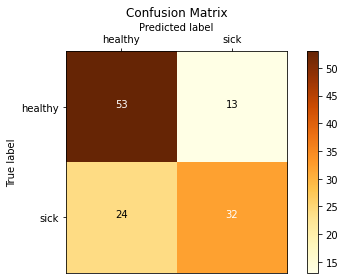

In [36]:
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

### [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

[Text(0.5, 0.8333333333333334, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.25, 0.5, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

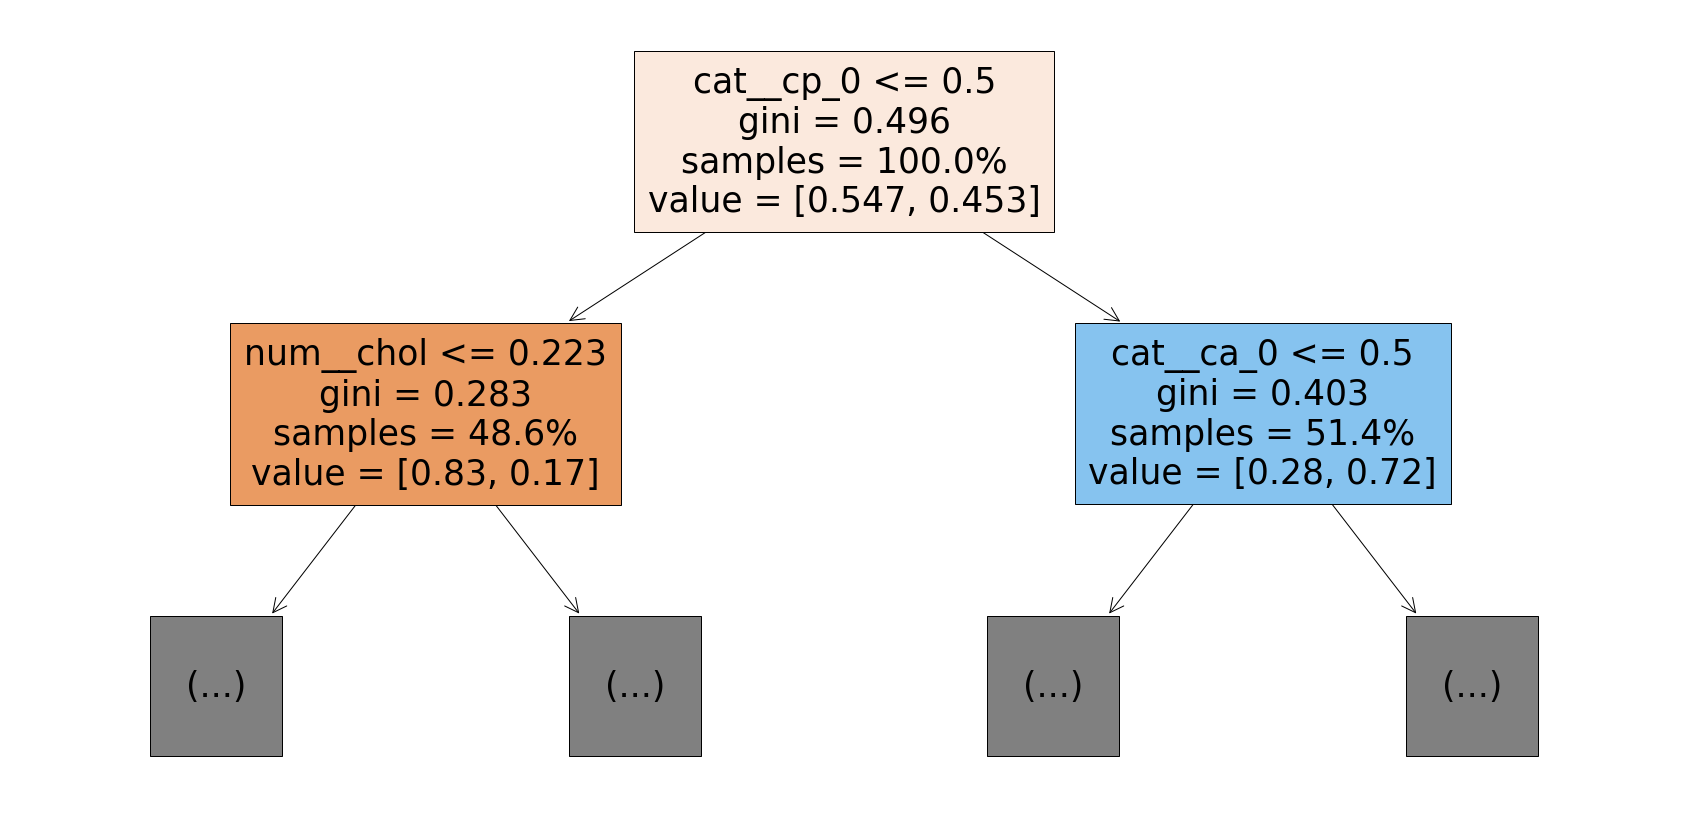

In [37]:
plt.figure(figsize = (30,15))
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

**What is the gini index improvement of the first split?**

Response: 0.496 - ((0.486 * 0.283) + (0.514 * 0.403)) = 0.15132

### [5 pts] Plot the importance of each feature for the Decision Tree

<Axes: >

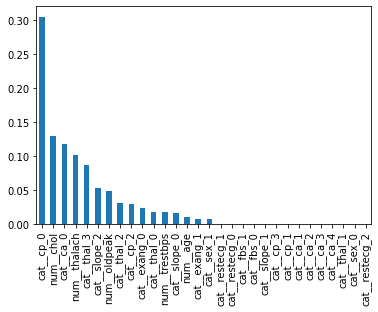

In [38]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

Response: There are 16 features with non-zero importance, and removing the ones with zero importance will not change the decision tree for the same sampled data.

### [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a GridSearchCV with 3-Fold Cross Validation for the Decision Tree. Find the best model parameters amongst the following:

- max_depth = [1,2,3,4,5,10,15]
- min_samples_split = [2,4,6,8]
- criterion = ["gini", "entropy"]

After using GridSearchCV, print the best model parameters and the best score.

In [39]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3)

grid_search.fit(x, y)


print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Best score: 0.7854785478547855


**Using the best model you have, report the test accuracy and print out the confusion matrix**

Test Accuracy: 0.8114754098360656


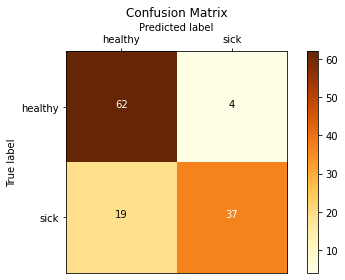

In [40]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_raw)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(target_test, y_pred)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, y_pred, ['healthy', 'sick'])

## (20 pts) Multi-Layer Perceptron

### [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(100,100) and max_iter = 800. **Report the accuracy and print the confusion matrix**. Make sure to set random_state=0. 

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Accuracy: 0.9392265193370166


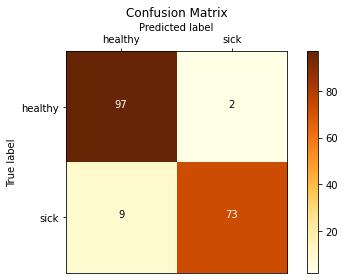

In [41]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=800, random_state=0)
mlp_classifier.fit(train_raw, target)
y_train_pred = mlp_classifier.predict(train_raw)
train_accuracy = accuracy_score(target, y_train_pred)
print("Train Accuracy:", train_accuracy)

draw_confusion_matrix(target, y_train_pred, ['healthy', 'sick'])

### [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [42]:
# Create the Decision Tree classifier with default parameters
dt_classifier = DecisionTreeClassifier()

# Create the MLP classifier with the previously mentioned parameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=800, random_state=0)

# Measure the training times
start_time = time.time()
dt_classifier.fit(train_raw, target)
dt_training_time = time.time() - start_time

start_time = time.time()
mlp_classifier.fit(train_raw, target)
mlp_training_time = time.time() - start_time

# Measure the prediction times
start_time = time.time()
dt_predictions = dt_classifier.predict(test_raw)
dt_prediction_time = time.time() - start_time

start_time = time.time()
mlp_predictions = mlp_classifier.predict(test_raw)
mlp_prediction_time = time.time() - start_time

# Print the timings
print("Training Time:")
print("Decision Tree: {:.4f} seconds".format(dt_training_time))
print("MLP: {:.4f} seconds".format(mlp_training_time))

print("\nPrediction Time:")
print("Decision Tree: {:.4f} seconds".format(dt_prediction_time))
print("MLP: {:.4f} seconds".format(mlp_prediction_time))

# Compare which model was quicker
if dt_training_time < mlp_training_time:
    print("\nDecision Tree was quicker for training.")
else:
    print("\nMLP was quicker for training.")

if dt_prediction_time < mlp_prediction_time:
    print("Decision Tree was quicker for prediction.")
else:
    print("MLP was quicker for prediction.")


Training Time:
Decision Tree: 0.0061 seconds
MLP: 1.4690 seconds

Prediction Time:
Decision Tree: 0.0021 seconds
MLP: 0.0028 seconds

Decision Tree was quicker for training.
Decision Tree was quicker for prediction.


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


### [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response: One advantage of MLP over Decision Tree is that it can capture non-linear relationships. A disadvantage is that its internal workings are very complex and is overall more difficult to interpret compared to Decision Tree

## (35 pts) PCA

### [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [43]:
# Create the PCA model with 10 components
pca = PCA(n_components=10)

# Fit the PCA model to the training data and transform it
X_train_pca = pca.fit_transform(train_raw)

# Get the principal components
components = pca.components_

# Print the 10 principal components
for i in range(10):
    print("Principal Component {}: {}".format(i+1, components[i]))

Principal Component 1: [ 2.86302825e-02 -1.57112401e-03 -1.07081012e-03  3.06295216e-02
  9.99068335e-01 -3.62199146e-04 -1.83163373e-03  9.09393485e-03
  7.20851679e-04  2.75262314e-03 -9.24029293e-04  1.01649988e-03
  2.19465285e-03]
Principal Component 2: [ 1.78551783e-01  1.10060700e-03 -1.56111507e-02  2.34612134e-01
 -3.72197428e-03  9.43064773e-04 -1.87604619e-03 -9.55041306e-01
  8.48205273e-03  2.00625169e-02 -1.21725721e-02  8.92892650e-03
  2.64264742e-03]
Principal Component 3: [ 6.69982412e-02 -9.11728712e-04  7.59615929e-03  9.65177653e-01
 -3.38334570e-02  4.54618399e-03 -5.03130343e-03  2.49984452e-01
 -1.64177537e-03  1.27102571e-02 -2.19480478e-03  5.13810654e-03
  2.53505829e-03]
Principal Component 4: [ 0.98093855 -0.00260164  0.00740661 -0.10979537 -0.02618754  0.00356488
 -0.007676    0.15652915 -0.00727866  0.0028835   0.00282966  0.01731617
 -0.00386897]
Principal Component 5: [-0.01167845  0.06160306 -0.30419363 -0.01643598 -0.00289867 -0.02235402
 -0.02936273 

### [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [44]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the percentage of variance explained by the top 10 principal components
print("Percentage of variance explained by the top 10 principal components:")
for i in range(10):
    print("Principal Component {}: {:.2f}%".format(i+1, explained_variance_ratio[i] * 100))

Percentage of variance explained by the top 10 principal components:
Principal Component 1: 76.83%
Principal Component 2: 13.65%
Principal Component 3: 7.94%
Principal Component 4: 1.47%
Principal Component 5: 0.04%
Principal Component 6: 0.02%
Principal Component 7: 0.02%
Principal Component 8: 0.01%
Principal Component 9: 0.01%
Principal Component 10: 0.01%


### [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [45]:
# Fit the PCA model to the training data and transform it
train_pca = pca.fit_transform(train_raw)

# Transform the testing data using the trained PCA model
test_pca = pca.transform(test_raw)

### [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy: 0.6885


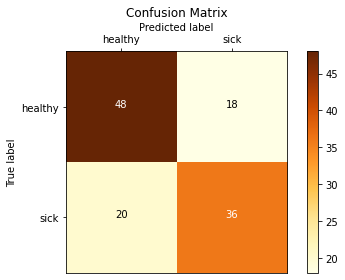

In [46]:
# Create the Decision Tree Classifier with default parameters
dt_classifier = DecisionTreeClassifier()

# Fit the Decision Tree Classifier to the PCA-transformed training data
dt_classifier.fit(train_pca, target)

# Predict using the PCA-transformed testing data
dt_predictions = dt_classifier.predict(test_pca)

# Calculate accuracy
accuracy = accuracy_score(target_test, dt_predictions)
print("Accuracy: {:.4f}".format(accuracy))

# Print confusion matrix
draw_confusion_matrix(target_test, dt_predictions, ['healthy', 'sick'])

**Does the model perform better with or without PCA?**

Response: The model seems to perform better without PCA

### [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy: 0.7049


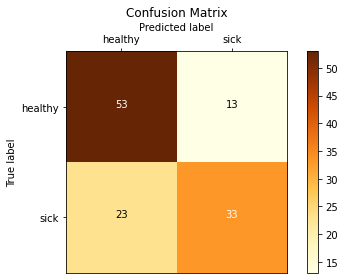

In [47]:
# Create the MLP classifier with the same parameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=1000, random_state=0)

# Fit the MLP classifier to the PCA-transformed training data
mlp_classifier.fit(train_pca, target)

# Predict using the PCA-transformed testing data
mlp_predictions = mlp_classifier.predict(test_pca)

# Calculate accuracy
accuracy = accuracy_score(target_test, mlp_predictions)
print("Accuracy: {:.4f}".format(accuracy))

# Print the confusion matrix
draw_confusion_matrix(target_test, mlp_predictions, ['healthy', 'sick'])

**Does the model perform better with or without PCA?**

Response: Again, the model seems to perform better without PCA

### [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response: A pro of PCA is that it reduces the dimensionality of our data and lets us capture important patterns/trends without unnecessary aditional information. Also, by transforming the original features into principal components, we might be able to discover hidden factors that explain our variance more easily. A con of PCA is the potential loss of information in the process of dimensionality reduction. Aditionally, the principal components resulting from our use of PCA might not be directly interpretable. 

## (20 pts) K-Means Clustering

### [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and random_state = 0.

In [48]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
kmeans.fit(train_raw)

# Print the inertia score
inertia_score = kmeans.inertia_
print("Inertia score:", inertia_score)

Inertia score: 204250.49577472528


### [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 20. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use random_state = 0.

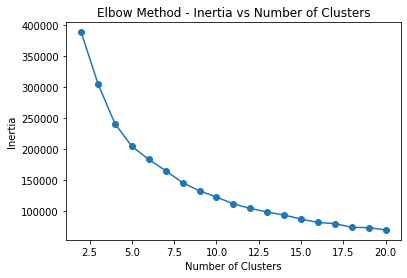

In [49]:
cluster_sizes = range(2, 21)
inertia_scores = []

for n_clusters in cluster_sizes:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(train_raw)
    inertia_scores.append(kmeans.inertia_)

# Plotting the inertia scores
plt.plot(cluster_sizes, inertia_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Inertia vs Number of Clusters')
plt.show()

The elbow is not exactly obvious, but it seems to start around 5 to 10

### [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

Inertia score: 204171.25964618797


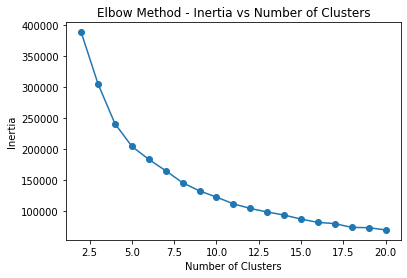

In [50]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
kmeans.fit(train_pca)

# Print the inertia score
inertia_score = kmeans.inertia_
print("Inertia score:", inertia_score)

cluster_sizes = range(2, 21)
inertia_scores = []

for n_clusters in cluster_sizes:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(train_pca)
    inertia_scores.append(kmeans.inertia_)

# Plotting the inertia scores
plt.plot(cluster_sizes, inertia_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Inertia vs Number of Clusters')
plt.show()

The elbow is once again not immediately obvious but seems to start around 5 to 10 

**Notice that the inertia is much smaller for every cluster size when using PCA features. Why do you think this is happening? Hint: Think about what Inertia is calculating and consider the number of features that PCA outputs.**

Response: PCA transform a high dimension feature space to a lower dimension space. Inertia is the sum of squared distances between each data point and its assigned cluster centroid. With a significantly lower number of features, the distances between data points become more concentrated in the lower-dimensional space, resulting in smaller inertia values for each cluster size. 

# (100 pts) Putting it all together

Through all the homeworks and projects, you have learned how to apply many different models to perform a supervised learning task. We are now asking you to take everything that you learned to create a model that can predict whether a hotel reservation will be canceled or not.


**Context**

Hotels see millions of people every year and always wants to keep rooms occupied and payed for. Cancellations make the business lose money since it may make it difficult to reserve to another customer on such short notice. As such, it is useful for a hotel to know whether a reservation is likely to cancel or not. The following dataset will provide a variety of information about a booking that you will use to predict whether that booking will cancel or not. 


Property Management System - PMS

**Attribute Information**

(C) is for Categorical 

(N) is for Numeric

    1) is_canceled (C) : Value indicating if the booking was canceled (1) or not (0).
    2) hotel (C) : The datasets contains the booking information of two hotel. One of the hotels is a resort hotel and the other is a city hotel.
    3) arrival_date_month (C): Month of arrival date with 12 categories: “January” to “December”
    4) stays_in_weekend_nights (N): Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    5) stays_in_week_nights (N): Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel BO and BL/Calculated by counting the number of week nights
    6) adults (N): Number of adults
    7) children (N): Number of children
    8) babies (N): Number of babies
    9) meal (C): Type of meal
    10) country (C): Country of origin.
    11) previous_cancellations (N): Number of previous bookings that were canceled by the customer prior to the current booking
    12) previous_bookings_not_canceled (N) : Number of previous bookings not canceled by the customer prior to the current booking
    13) reserved_room_type (C): Code of room type reserved. Code is presented instead of designation for anonymity reasons
    14) booking_changes (N) : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
    15) deposit_type (C) : No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay
    16) days_in_waiting_list (N): Number of days the booking was in the waiting list before it was confirmed to the customer
    17) customer_type (C): Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
    18) adr (N): Average Daily Rate (Calculated by dividing the sum of all lodging transactions by the total number of staying nights)
    19) required_car_parking_spaces (N): Number of car parking spaces required by the customer
    20) total_of_special_requests (N): Number of special requests made by the customer (e.g. twin bed or high floor)
    21) name (C): Name of the Guest (Not Real)
    22) email (C): Email (Not Real)
    23) phone-number (C): Phone number (not real)

This dataset is quite large with 86989 samples. This makes it difficult to just brute force running a lot of models. As such, you have to be thoughtful when designing your models.

The file name for the training data is "hotel_booking.csv".

**Challenge**

This project is about being able to predict whether a reservation is likely to cancel based on the
input parameters available to us. We will ask you to perform some specific instructions to lead you in the right direction but you are given free reign on which models to use and the preprocessing steps you make. We will ask you to **write out a description of what models you choose and why you choose them**.

## (50 pts) Preprocessing


**Preprocessing:**
For the dataset, the following are mandatory pre-processing steps for your data:

- Use One-Hot Encoding on all categorical features (specify whether you keep the extra feature or not for features with multiple values)
- Determine which fields need to be dropped
- Handle missing values (Specify your strategy)
- Rescale the real valued features using any strategy you choose (StandardScaler, MinMaxScaler, Normalizer, etc)
- Augment at least one feature
- Implement a train-test split with 20% of the data going to the test data. Make sure that the test and train data are balanced in terms of the desired class.


After writing your preprocessing code, write out a description of what you did for each step and provide a justification for your choices. All descriptions should be written in the markdown cells of the jupyter notebook. Make sure your writing is clear and professional.  

We highly recommend reading through the [scikit-learn documentation](https://scikit-learn.org/stable/data_transforms.html) to make this part easier.

In [51]:
# Load the dataset
df = pd.read_csv("datasets/hotel_booking.csv")

# Drop irrelevant fields
df = df.drop(['name', 'email', 'phone-number'], axis=1)

# Check number of missing values
print(df.isna().sum())

# Drop missing values as there are not too many of them
df = df.dropna()

# Define the categorical and numerical features
categorical_features = ['hotel', 'arrival_date_month', 'meal', 'country', 'reserved_room_type', 'deposit_type', 'customer_type']
numerical_features = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations',
                      'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
                      'total_of_special_requests']

# Create preprocessing transformers
categorical_transformer = OneHotEncoder(sparse=False, drop='first')
numerical_transformer = StandardScaler()

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Augment features
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Split the data into features and target
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Make sure train and test data are balanced
class_distribution = pd.Series(y).value_counts(normalize=True)
print("Class distribution in the original dataset:")
print(class_distribution)
train_class_distribution = pd.Series(y_train).value_counts(normalize=True)
test_class_distribution = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution in the train set:")
print(train_class_distribution)
print("\nClass distribution in the test set:")
print(test_class_distribution)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit and transform the training data
X_train_preprocessed = pipeline.fit_transform(X_train)

# Transform the test data
X_test_preprocessed = pipeline.transform(X_test)

is_canceled                       0
hotel                             0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          3
babies                            0
meal                              0
country                           0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64
Class distribution in the original dataset:
is_canceled
0    0.594211
1    0.405789
Name: proportion, dtype: float64

Class distribution in the train set:
is_canceled
0    0.594214
1    0.405786
Name: proportion, dtype: float64

Cl

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Preprocessing Steps:

One-Hot Encoding: I applied one-hot encoding to all categorical features in the dataset. This converts categorical variables into binary vectors, allowing the machine learning models to work effectively with the data. For features with multiple values, I kept the extra feature. As mentioned, this creates a binary indicator for each possible category within a feature, capturing all the available information without assuming any ordinal relationship between categories.

Dropping Fields: I dropped the fields that are not useful for the prediction task or contain information that is not relevant for the model. In this case, I dropped the fields 'name', 'email', and 'phone-number' as they do not contribute to predicting whether a reservation will be canceled or not.

Handling Missing Values: There are only a few missing values, so I choose to remove those samples.

Feature Scaling: I rescaled the real-valued features in the dataset to a similar range to avoid any particular feature dominating the learning process. I used the StandardScaler, which scales the features to have zero mean and unit variance.

Augmenting Features: I calculated the total number of nights stayed by summing the 'stays_in_weekend_nights' and 'stays_in_week_nights' features. This can capture the overall duration of the stay and potentially improve the model's predictive performance.

Train-Test Split: I split the preprocessed data into training and testing sets using a 80:20 ratio

## (50 pts) Try out a few models
Now that you have pre-processed your data, you are ready to try out different models. 

For this part of the project, we want you to experiment with all the different models demonstrated in the course to determine which one performs best on the dataset.

You must perform classification using at least 3 of the following models:
- Logistic Regression
- K-nearest neighbors
- SVM
- Decision Tree
- Multi-Layer Perceptron

Due to the size of the dataset, be careful which models you use and look at their documentation to see how you should tackle this size issue for each model.

For full credit, you must perform some hyperparameter optimization on your models of choice. You may find the following scikit-learn library on [hyperparameter optimization](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) useful.

For each model chosen, write a description of which models were chosen, which parameters you optimized, and which parameters you choose for your best model. 
While the previous part of the project asked you to pre-process the data in a specific manner, you may alter pre-processing step as you wish to adjust for your chosen classification models.


In [52]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg_params = {'C': [0.1, 1, 10]}
logreg_grid = GridSearchCV(logreg, logreg_params, cv=5)
logreg_grid.fit(X_train_preprocessed, y_train)
logreg_best = logreg_grid.best_estimator_

Logistic Regression Test Accuracy: 0.7979307702133095


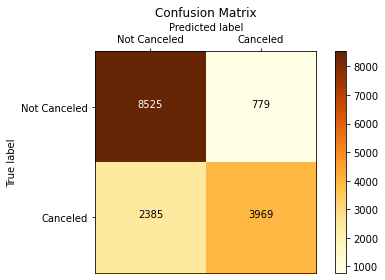

In [53]:
# Evaluate Logistic Regression
y_pred_logreg = logreg_best.predict(X_test_preprocessed)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression Test Accuracy:", accuracy_logreg)

# Confusion matrix for Logistic Regression
classes = ['Not Canceled', 'Canceled']
draw_confusion_matrix(y_test, y_pred_logreg, classes)

Logistic Regression is a linear model widely used for binary classification. It's computationally efficient and can handle large datasets.
I optimized the C parameter, which represents the inverse of regularization strength. I tuned this parameter using cross-validation to find the optimal value that balances between overfitting and underfitting.
The best model is selected based on the highest cross-validation accuracy.

In [54]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=0)
dt_params = {'max_depth': [None, 5, 10, 15]}
dt_grid = GridSearchCV(dt, dt_params, cv=5)
dt_grid.fit(X_train_preprocessed, y_train)
dt_best = dt_grid.best_estimator_

Decision Tree Test Accuracy: 0.8305658449354962


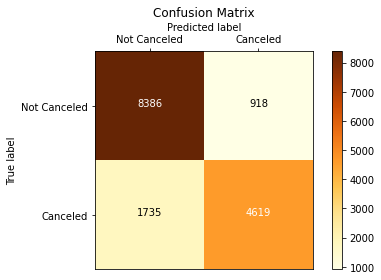

In [55]:
# Evaluate Decision Tree
y_pred_dt = dt_best.predict(X_test_preprocessed)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Accuracy:", accuracy_dt)

# Confusion matrix for Decision Tree
draw_confusion_matrix(y_test, y_pred_dt, classes)

Decision Tree is a non-linear model that learns decision rules to classify instances. It can handle large datasets but may overfit if not properly regularized.
I optimized the max_depth parameter, which controls the maximum depth of the decision tree. I searched for the optimal value using cross-validation.
The best model is selected based on the highest cross-validation accuracy.

In [56]:
# K-nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [1, 3, 5, 7]}
knn_grid = GridSearchCV(knn, knn_params, cv=5)
knn_grid.fit(X_train_preprocessed, y_train)
knn_best = knn_grid.best_estimator_

K-nearest Neighbors Test Accuracy: 0.8326095286754375


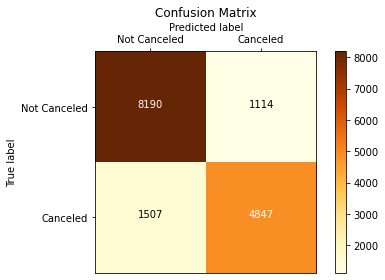

In [57]:
# Evaluate K-nearest Neighbors
y_pred_knn = knn_best.predict(X_test_preprocessed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("K-nearest Neighbors Test Accuracy:", accuracy_knn)

# Confusion matrix for K-nearest Neighbors
draw_confusion_matrix(y_test, y_pred_knn, classes)

KNN is a non-parametric classification algorithm that works by finding the k nearest neighbors to a given data point and classifying it based on the majority class of those neighbors.
To optimize the KNN model, I focused on the n_neighbors parameter, which specifies the number of neighbors to consider when making predictions. I created a parameter grid knn_params with different values for n_neighbors [1, 3, 5, 7].
I used GridSearchCV to perform a grid search with 5-fold cross-validation (cv=5) to evaluate the different values of n_neighbors and select the best performing model. After performing the grid search, I obtained the best model by accessing the best_estimator_ attribute of the GridSearchCV object.

## Extra Credit 

We have provided an extra test dataset named "hotel_booking_test.csv" that does not have the target labels. Classify the samples in the dataset with your best model and write them into a csv file. Submit your csv file to our [Kaggle](https://www.kaggle.com/t/ed725123bf124e9199c1d8fdc8a2d9c7) contest. The website will specify your classification accuracy on the test set. We will award a bonus point for the project for every percentage point over 75% that you get on your kaggle test accuracy.

To get the bonus points, you must also write out a summary of the model that you submit including any changes you made to the pre-processing steps. The summary must be written in a markdown cell of the jupyter notebook. Note that you should not change earlier parts of the project to complete the extra credit. 

**Kaggle Submission Instruction**
Submit a two column csv where the first column is named "ID" and is the row number. The second column is named "target" and is the classification for each sample. Make sure that the sample order is preserved.

In [67]:
test_df = pd.read_csv("datasets/hotel_booking_test.csv")
test_df = test_df.fillna(0)
X_test_preprocessed = pipeline.transform(test_df)
y_pred_test = knn_best.predict(X_test_preprocessed)
submission_df = pd.DataFrame({'ID': test_df.index, 'target': y_pred_test})
submission_df.to_csv('hotel_booking_submission.csv', index=False)

I filled the NA value in children with 0 because the mean of the children column is close to 0. 

My best model was KNN. KNN is a non-parametric classification algorithm that works by finding the k nearest neighbors to a given data point and classifying it based on the majority class of those neighbors.
To optimize the KNN model, I focused on the n_neighbors parameter, which specifies the number of neighbors to consider when making predictions. I created a parameter grid knn_params with different values for n_neighbors [1, 3, 5, 7].
I used GridSearchCV to perform a grid search with 5-fold cross-validation (cv=5) to evaluate the different values of n_neighbors and select the best performing model. After performing the grid search, I obtained the best model by accessing the best_estimator_ attribute of the GridSearchCV object.

I preproccessed the data using the same pipeline as earlier in the assignment. Here is the description of those preprocessing steps again:

Preprocessing Steps:

One-Hot Encoding: I applied one-hot encoding to all categorical features in the dataset. This converts categorical variables into binary vectors, allowing the machine learning models to work effectively with the data. For features with multiple values, I kept the extra feature. As mentioned, this creates a binary indicator for each possible category within a feature, capturing all the available information without assuming any ordinal relationship between categories.

Dropping Fields: I dropped the fields that are not useful for the prediction task or contain information that is not relevant for the model. In this case, I dropped the fields 'name', 'email', and 'phone-number' as they do not contribute to predicting whether a reservation will be canceled or not.

Handling Missing Values: There are only a few missing values, so I choose to remove those samples.

Feature Scaling: I rescaled the real-valued features in the dataset to a similar range to avoid any particular feature dominating the learning process. I used the StandardScaler, which scales the features to have zero mean and unit variance.

Augmenting Features: I calculated the total number of nights stayed by summing the 'stays_in_weekend_nights' and 'stays_in_week_nights' features. This can capture the overall duration of the stay and potentially improve the model's predictive performance.

Train-Test Split: I split the preprocessed data into training and testing sets using a 80:20 ratio